# Predicting Heart Disease

**Authors: Elnaz Azizi, Charly Watts, Christian Unterrainer**

## 1. Introduction & Objective

This notebook aims to predict the presence of heart disease using machine learning techniques. We will be working with subsets of the **UCI Heart Disease Dataset**, specifically the data from:
1.  Cleveland Clinic Foundation
2.  Swiss University Hospital, Basel/Zurich
3.  Hungarian Institute of Cardiology, Budapest

These datasets are commonly used benchmarks for this classification task.

**Objective:**
The primary goal is to build, evaluate, and compare several classification models:
1. Logistic Regression (Baseline)
2. K-Nearest Neighbors (KNN) (Baseline)
3. Gaussian Naive Bayes (Baseline)
4. Gradient Boosting Classifier
5. MLP Classifier (Neural Network)
6. Random Forest Classifier
7. Support Vector Machine (SVM) Classifier
8. XGBoost Classifier

We will employ appropriate data preprocessing steps, including imputation and scaling. Model evaluation will primarily focus on the **F2-score** for the positive class (presence of heart disease).

**Why F2-score?** The F2-score ($\\beta=2$) weights Recall (Sensitivity - correctly identifying positive cases) twice as much as Precision (Positive Predictive Value - proportion of predicted positives that are actually positive). In medical screening for serious conditions like heart disease, minimizing false negatives (missing a disease case) is often considered more critical than minimizing false positives (incorrectly flagging a healthy person), as a false negative can lead to delayed treatment and poorer outcomes. Optimizing for F2 aligns the model evaluation with this clinical priority.

Two main evaluation strategies will be explored:
- **Nested Cross-Validation:** To obtain a robust estimate of model generalization performance, optimizing and reporting the F2-score.
- **Train/Test Split with GridSearchCV & Threshold Optimization:** To identify a specific "best" model configuration and optimize its decision threshold on the test set to maximize the F2-score.

The notebook will walk through data loading, preprocessing, model pipeline definition, evaluation, and visualization of the results.

## 2. Imports

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
# Import fbeta_score explicitly for clarity
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, f1_score, auc, make_scorer, fbeta_score 
from IPython.display import display
from xgboost import XGBClassifier 

## 3. Data Loading and Initial Preparation

### 3.1. Load Data from Files
We load three processed datasets originating from the UCI Heart Disease repository: Cleveland, Switzerland, and Hungarian. Missing values are denoted by '?' in the raw files. The Hungarian dataset is space-separated, while the others are comma-separated.

In [69]:
file_info = [
    ('data/processed.cleveland.data', False),
    ('data/processed.switzerland.data', False),
    ('data/reprocessed.hungarian.data', True),  # space-separated
]
col_names = [
    'age','sex','cp','trestbps','chol','fbs',
    'restecg','thalach','exang','oldpeak',
    'slope','ca','thal','target'
]
dataframes = []
df_names = ['Cleveland', 'Switzerland', 'Hungarian'] 
for path, is_space_separated in file_info:
    if is_space_separated:
        df = pd.read_csv(path, sep=r'\s+', header=None, names=col_names, na_values='?')
    else:
        df = pd.read_csv(path, header=None, names=col_names, na_values='?')
    
    dataframes.append(df)

### 3.2. Initial Data Inspection (Brief)

In [70]:
for df_name, df in zip(df_names, dataframes):
    print(f"\n--- {df_name} Dataset Info ---")
    df.info()
    print(f"\n--- Missing Values in {df_name} (Count) ---")
    print(df.isnull().sum())


--- Cleveland Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB

--- Missing Values in Cleveland (Count) ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
sl

## 4. Data Preparation for Modeling

### 4.1. Target Variable Transformation and Train-Test Split
The target variable is binarized (0: no disease, 1: presence of disease). Data is then split into stratified training and testing sets. Proportions are printed to 4 decimal places for readability.

In [71]:
splits = []
for df, (path, _) in zip(dataframes, file_info):
    dataset_name_from_path = path.split('/')[-1] 
    df['target'] = df['target'].astype(int).apply(lambda v: 1 if v > 0 else 0)
    x = df.drop(columns='target')
    y = df['target']
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y 
    )
    splits.append({
        "dataset": dataset_name_from_path,
        "x_train": x_train, "x_test": x_test,
        "y_train": y_train, "y_test": y_test
    })
    print(f"\n--- Target distribution in {dataset_name_from_path} (Binarized) ---")
    original_dist = {k: f'{v:.4f}' for k, v in y.value_counts(normalize=True).sort_index().to_dict().items()}
    train_dist = {k: f'{v:.4f}' for k, v in y_train.value_counts(normalize=True).sort_index().to_dict().items()}
    test_dist = {k: f'{v:.4f}' for k, v in y_test.value_counts(normalize=True).sort_index().to_dict().items()}
    print(f"Original: {original_dist}")
    print(f"Train:    {train_dist}")
    print(f"Test:     {test_dist}")


--- Target distribution in processed.cleveland.data (Binarized) ---
Original: {0: '0.5413', 1: '0.4587'}
Train:    {0: '0.5413', 1: '0.4587'}
Test:     {0: '0.5410', 1: '0.4590'}

--- Target distribution in processed.switzerland.data (Binarized) ---
Original: {0: '0.0650', 1: '0.9350'}
Train:    {0: '0.0612', 1: '0.9388'}
Test:     {0: '0.0800', 1: '0.9200'}

--- Target distribution in reprocessed.hungarian.data (Binarized) ---
Original: {0: '0.6395', 1: '0.3605'}
Train:    {0: '0.6383', 1: '0.3617'}
Test:     {0: '0.6441', 1: '0.3559'}


### 4.2. Feature Column Configuration

In [72]:
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

### 4.3. Preprocessing Pipeline Definition
Numeric features are imputed with the median and scaled. Categorical features are imputed with the most frequent value, and an indicator for imputation is added.

In [73]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
])

## 5. Modeling Pipeline Definition

### 5.1. Full Model Pipelines
Pipelines are defined for each classifier, integrating the preprocessor. `random_state` is set for reproducibility where applicable.

In [74]:
logistic_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
kneighbors_pipeline = Pipeline([
    ('pre', preprocessor),
    ('knn', KNeighborsClassifier())
])
naive_pipeline = Pipeline([
    ('pre', preprocessor),
    ('nav', GaussianNB())
])
gradient_boosting_pipeline = Pipeline([
    ('pre', preprocessor),
    ('gbc', GradientBoostingClassifier(random_state=42))
])
mlp_pipeline = Pipeline([
    ('pre', preprocessor),
    ('mlp', MLPClassifier(random_state=42, max_iter=3000)) 
])
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])
svm_pipeline = Pipeline([
    ('pre', preprocessor),
    ('svc', SVC(random_state=42, probability=True))
])

xgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
])

### 5.2. Hyperparameter Grids
Hyperparameter search spaces are defined for each model (except Naive Bayes). Grids are kept relatively small for manageable runtimes.

In [75]:
logistic_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10]
}
kneighbors_param_grid = {
    'knn__n_neighbors': list(range(1, 21))
}
naive_param_grid = {}  

gradient_boosting_param_grid = {
    'gbc__n_estimators': [100, 200],       
    'gbc__learning_rate': [0.05, 0.1],     
    'gbc__max_depth': [3, 5],                  
    'gbc__subsample': [0.8],                
    'gbc__min_samples_split': [5],         
    'gbc__min_samples_leaf': [3]           
}

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100, 50), (75, 50, 25)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
    'mlp__learning_rate_init': [0.01, 0.001, 0.0001],
    'mlp__early_stopping': [True],
    'mlp__n_iter_no_change': [10, 20],
    'mlp__max_iter': [3000, 5000] 
}

rf_param_grid = {
    'rf__n_estimators' : [100, 200],             
    'rf__max_depth' : [None, 10, 20],            
    'rf__min_samples_split' : [2, 5],             
    'rf__min_samples_leaf' : [1, 2],              
    'rf__class_weight': ['balanced', None]        
}

svm_param_grid = {
    'svc__C': [0.1, 1, 10],                       
    'svc__kernel': ['linear', 'rbf'],             
    'svc__gamma': ['scale', 'auto', 0.1]          
}

xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1]
}

### 5.3. Model Configurations Dictionary
A dictionary mapping model names to their pipelines and hyperparameter grids for streamlined evaluation.

In [76]:
model_configurations = {
    "Logistic Regression": (logistic_pipeline, logistic_param_grid),
    "K Nearest Neighbors": (kneighbors_pipeline, kneighbors_param_grid),
    "Naive Bayes": (naive_pipeline, naive_param_grid),
    "Gradient Boosting": (gradient_boosting_pipeline, gradient_boosting_param_grid),
    "MLP Classifier": (mlp_pipeline, mlp_param_grid),
    "Random Forest": (rf_pipeline, rf_param_grid),
    "SVM Classifier": (svm_pipeline, svm_param_grid),
    "XGBoost" : (xgb_pipeline, xgb_param_grid)
}

## 6. Model Evaluation Strategies

### 6.1. Nested Cross-Validation for Robust Performance Estimation (Optimizing & Reporting F2-score)
Nested CV provides a less biased estimate of model generalization performance. The outer loop evaluates, while the inner loop tunes hyperparameters. **F2-score** is the primary metric used for both tuning and evaluation.

To reduce the computational time, we are using `RandomizedSearchCV` instead of `GridSearchCV` for the inner loop. This probes a fixed number of random parameter combinations (`n_iter`) from the search space rather than exhaustively checking all of them. `n_jobs=-1` is used to parallelize the search across available CPU cores.

In [77]:
nested_cv_results_summary = []

random_search_n_iter = 20
beta_value = 2 # Define the beta value for fbeta_score

# Create an F2-score scorer
f2_scorer = make_scorer(fbeta_score, beta=beta_value)


for split_data in splits:
    dataset_name = split_data["dataset"]
    print(f"Running Nested CV for dataset: {dataset_name}")

    X_full = pd.concat([split_data["x_train"], split_data["x_test"]], ignore_index=True)
    y_full = pd.concat([split_data["y_train"], split_data["y_test"]], ignore_index=True)

    for model_name, (pipeline, param_grid) in model_configurations.items():
        print(f"  Model: {model_name}")
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Use RandomizedSearchCV for the inner loop for faster tuning
        # Scoring is set to the F2-score scorer
        if model_name == "Naive Bayes":
             # Naive Bayes has no grid, evaluate directly within outer loop.
             # Ensure the direct evaluation also uses the F2-score scorer
             inner_model = pipeline
        else:
             inner_model = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_grid,
                n_iter=random_search_n_iter,
                cv=inner_cv,
                scoring=f2_scorer, # Use F2 scorer here
                random_state=42,
                n_jobs=-1,
                # verbose=1
             )

        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # cross_val_score uses the F2 scorer
        nested_f2_scores = cross_val_score(inner_model, X_full, y_full, cv=outer_cv, scoring=f2_scorer, n_jobs=-1, verbose=1)

        nested_cv_results_summary.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Nested F2 Mean": nested_f2_scores.mean(), # Corrected column name to F2
            "Nested F2 Std": nested_f2_scores.std()   # Corrected column name to F2
        })

nested_cv_df = pd.DataFrame(nested_cv_results_summary)
print("\n--- Nested Cross-Validation Results Summary (Optimizing & Reporting F2-score) ---") # Corrected title
# Pivoted table for better readability, dataset as index, model as columns
# Use the corrected column name for pivoting
nested_cv_pivot_df = nested_cv_df.pivot_table(index="Dataset", columns="Model", values="Nested F2 Mean").round(4)
display(nested_cv_pivot_df)

Running Nested CV for dataset: processed.cleveland.data
  Model: Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is sm

  Model: K Nearest Neighbors


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: Naive Bayes
  Model: Gradient Boosting


/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use Gri

  Model: MLP Classifier


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: Random Forest


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.7s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.w

  Model: SVM Classifier


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: XGBoost


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/

Running Nested CV for dataset: processed.switzerland.data
  Model: Logistic Regression


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: K Nearest Neighbors


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Pyt

  Model: Naive Bayes
  Model: Gradient Boosting


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: MLP Classifier


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: Random Forest


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.8s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.w

  Model: SVM Classifier


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: XGBoost


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/

Running Nested CV for dataset: reprocessed.hungarian.data
  Model: Logistic Regression


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: K Nearest Neighbors


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Pyt

  Model: Naive Bayes
  Model: Gradient Boosting


/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: MLP Classifier


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: Random Forest


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/charlywatts/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.w

  Model: SVM Classifier


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Model: XGBoost


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished



--- Nested Cross-Validation Results Summary (Optimizing & Reporting F2-score) ---


Model,Gradient Boosting,K Nearest Neighbors,Logistic Regression,MLP Classifier,Naive Bayes,Random Forest,SVM Classifier,XGBoost
Dataset,,,,,,,,
processed.cleveland.data,0.7525,0.7393,0.7551,0.6329,0.7410,0.7656,0.7668,0.7472
processed.switzerland.data,0.9584,0.9863,0.9863,0.9722,0.5700,0.9863,0.9863,0.9880
reprocessed.hungarian.data,0.6787,0.7080,0.7160,0.7090,0.7265,0.7150,0.6602,0.7018


### 6.2. Train/Test Split with GridSearchCV & Threshold Optimization (Optimizing Test Set Threshold for F2-score)
This approach tunes hyperparameters on the training set (optimizing for 'recall' in GridSearchCV to find models good at identifying positives), predicts probabilities on the test set, and then optimizes the decision threshold to maximize the **F2-score** on the test set.

In [78]:
detailed_classic_results = [] 

beta_value = 2 # Define the beta value for F2-score

for split_data in splits:
    dataset_name = split_data["dataset"]
    x_train = split_data["x_train"]
    y_train = split_data["y_train"]
    x_test = split_data["x_test"]
    y_test = split_data["y_test"]
    

    for model_name, (pipeline, param_grid) in model_configurations.items():
        # For Naive Bayes, GridSearchCV is not needed as there are no tuneable params in this grid
        if model_name == "Naive Bayes":
            model_to_fit = pipeline
            model_to_fit.fit(x_train, y_train) # Fit directly on training data
            best_params_found = {}
        else:
            # GridSearchCV tunes hyperparameters on training data (optimizing recall)
            # Note: Could also set scoring=make_scorer(fbeta_score, beta=2) here if preferred,
            # but recall is a reasonable intermediate goal.
            grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1) 
            grid.fit(x_train, y_train)
            model_to_fit = grid.best_estimator_
            best_params_found = grid.best_params_

        # Predict probabilities on the test set
        # Check if the model has predict_proba (SVC requires probability=True)
        if hasattr(model_to_fit, 'predict_proba'):
            y_probs = model_to_fit.predict_proba(x_test)[:, 1]
        elif hasattr(model_to_fit, 'decision_function'):
             # For models like SVM that might not have predict_proba by default, use decision_function
             # Note: This requires SVC(probability=True) if predict_proba is truly needed.
             # The current SVC config has probability=True, so predict_proba is used.
             print(f"Warning: {model_name} does not have predict_proba. Attempting decision_function.")
             y_probs = model_to_fit.decision_function(x_test)
             # Decision function values are not probabilities, threshold interpretation changes
             # For consistency with probability thresholding, let's assume predict_proba is available
             # if SVC(probability=True) is used. If not, a different approach is needed.
             # Since probability=True is set, this warning might not trigger unless there's an issue.
             continue # Skip if predict_proba is truly missing and can't fall back easily
        else:
            print(f"Warning: {model_name} does not have predict_proba or decision_function. Skipping threshold optimization.")
            continue # Skip this model if it can't provide scores

        # Calculate Precision-Recall curve and Fbeta scores across thresholds
        precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_probs)
        # Calculate F2-scores across the thresholds
        f_beta_scores_pr = (1 + beta_value**2) * (precisions * recalls) / (beta_value**2 * precisions + recalls + 1e-10)
        
        # Find the threshold that maximizes the F2-score
        # precision_recall_curve returns len(precisions) = len(recalls) = len(thresholds_pr) + 1
        # The last precision/recall pair corresponds to threshold=0 (or min score), which includes all positives.
        # The thresholds list does not include the lowest threshold.
        # We maximize over the scores calculated for thresholds
        if len(f_beta_scores_pr) > len(thresholds_pr):
             best_idx_pr = np.argmax(f_beta_scores_pr[:-1]) 
        else:
             best_idx_pr = np.argmax(f_beta_scores_pr)
        
        best_threshold = thresholds_pr[best_idx_pr]
        
        # Apply the optimized threshold to get final predictions
        y_pred_optimized = (y_probs >= best_threshold).astype(int)

        # Get classification report using the optimized predictions
        report_dict = classification_report(y_test, y_pred_optimized, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred_optimized)

        detailed_classic_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Best Estimator (from Grid Search)": model_to_fit, # Store the fitted estimator
            "Best Params (from Grid Search)": best_params_found,
            "Optimized Threshold (for F2)": best_threshold, # Stored as float, specify F2
            "Recall (Class 1, Opt Thresh)": report_dict.get('1', {}).get('recall', 0),
            "Precision (Class 1, Opt Thresh)": report_dict.get('1', {}).get('precision', 0),
            # This is the F1 score *at the F2-optimized threshold*. Let's keep it for information
            "F1-Score (at F2-Opt Thresh)": report_dict.get('1', {}).get('f1-score', 0),
            # This is the F2 score at the F2-optimized threshold - the main metric for this approach
            "F2-Score (Optimized Threshold)": f_beta_scores_pr[best_idx_pr], # Corrected column name to F2
            "Confusion Matrix": cm,
            "y_test": y_test,
            "y_probs": y_probs,
            "y_pred_optimized_thresh": y_pred_optimized,
            "precisions_pr": precisions, 
            "recalls_pr": recalls,       
            "f2_scores_pr": f_beta_scores_pr, # Store F2 scores calculated across curve
            "thresholds_pr": thresholds_pr
        })

threshold_optimization_summary_list = []
for res in detailed_classic_results:
    threshold_optimization_summary_list.append({
        "Dataset": res["Dataset"],
        "Model": res["Model"],
        "F2-Score (Optimized Threshold)": res["F2-Score (Optimized Threshold)"], # Use F2 score here
        "Optimized Threshold (for F2)": res["Optimized Threshold (for F2)"] # Keep as float for pivoting
    })
threshold_optimization_df_summary = pd.DataFrame(threshold_optimization_summary_list)

print("\n--- Threshold Optimization Approach Results Summary (Optimizing Test Set Threshold for F2) ---") # Corrected title
display(threshold_optimization_df_summary.pivot_table(
    index=['Dataset', 'Model'], 
    # Use F2 score column for values
    values=['F2-Score (Optimized Threshold)', 'Optimized Threshold (for F2)'] 
).round(4))


--- Threshold Optimization Approach Results Summary (Optimizing Test Set Threshold for F2) ---


F2-Score (Optimized Threshold)  \
Dataset                    Model                                                 
processed.cleveland.data   Gradient Boosting                            0.9310   
                           K Nearest Neighbors                          0.8544   
                           Logistic Regression                          0.9333   
                           MLP Classifier                               0.8092   
                           Naive Bayes                                  0.9272   
                           Random Forest                                0.9375   
                           SVM Classifier                               0.9032   
                           XGBoost                                      0.9396   
processed.switzerland.data Gradient Boosting                            0.9829   
                           K Nearest Neighbors                          0.9829   
                           Logistic Regression                          0.9829   
                           MLP Classifier                               0.9829   
                           Naive Bayes                                  0.9829   
                           Random Forest                                0.9829   
                           SVM Classifier                               0.9829   
                           XGBoost                                      0.9829   
reprocessed.hungarian.data Gradient Boosting                            0.8203   
                           K Nearest Neighbors                          0.8108   
                           Logistic Regression                          0.8252   
                           MLP Classifier                               0.8261   
                           Naive Bayes                                  0.8411   
                           Random Forest                                0.8547   
                           SVM Classifier                               0.8197   
                           XGBoost                                      0.7965   

                                                Optimized Threshold (for F2)  
Dataset                    Model                                              
processed.cleveland.data   Gradient Boosting                          0.4949  
                           K Nearest Neighbors                        0.3333  
                           Logistic Regression                        0.2934  
                           MLP Classifier                             0.2877  
                           Naive Bayes                                0.0000  
                           Random Forest                              0.4801  
                           SVM Classifier                             0.2314  
                           XGBoost                                    0.1939  
processed.switzerland.data Gradient Boosting                          0.0046  
                           K Nearest Neighbors                        0.6000  
                           Logistic Regression                        0.9309  
                           MLP Classifier                             0.7446  
                           Naive Bayes                                0.0000  
                           Random Forest                              0.5600  
                           SVM Classifier                             0.9259  
                           XGBoost                                    0.7668  
reprocessed.hungarian.data Gradient Boosting                          0.0273  
                           K Nearest Neighbors                        0.4000  
                           Logistic Regression                        0.4642  
                           MLP Classifier                             0.4770  
                           Naive Bayes                                0.2865  
                           Random Forest                              0.2516  
                   

## 7. Results Visualization and Comparison

### 7.1. Tabular F2-Score Comparison (All Models - Nested CV vs. Threshold Optimization)

In [79]:
# Prepare DataFrame for Threshold Optimization results, focusing on F2
thresh_opt_df_for_plot = pd.DataFrame([{
    "Dataset": res["Dataset"], 
    "Model": res["Model"], 
    "F2-Score": res["F2-Score (Optimized Threshold)"]} 
    for res in detailed_classic_results])
thresh_opt_df_for_plot["Type"] = "Threshold Optimization (F2-Opt Thresh)" # Clarify the type

# Prepare DataFrame for Nested CV results, using the F2 mean
nested_df_for_plot = nested_cv_df.copy()
nested_df_for_plot.rename(columns={
    "Nested F2 Mean": "F2-Score", # Use the corrected column name
    "Nested F2 Std": "F2-Score Std" # Keep Std if needed, but not used in concat below
    }, inplace=True)
nested_df_for_plot["Type"] = "Nested CV (F2 Mean)" # Clarify the type

# Combine the two DataFrames, selecting only relevant columns for comparison
combined_f2_df_for_comparison = pd.concat([
    thresh_opt_df_for_plot[["Dataset", "Model", "F2-Score", "Type"]],
    nested_df_for_plot[["Dataset", "Model", "F2-Score", "Type"]]
], ignore_index=True)

print("\n--- F2 Score Comparison: Nested CV vs. Threshold Optimization (All Models) ---") # Corrected title
# Pivot on the F2-Score column
pivot_table_f2_all_models = combined_f2_df_for_comparison.pivot_table(
    index=["Dataset", "Model"], 
    columns="Type", 
    values="F2-Score"
).round(4)
display(pivot_table_f2_all_models)


--- F2 Score Comparison: Nested CV vs. Threshold Optimization (All Models) ---


Type                                            Nested CV (F2 Mean)  \
Dataset                    Model                                      
processed.cleveland.data   Gradient Boosting                 0.7525   
                           K Nearest Neighbors               0.7393   
                           Logistic Regression               0.7551   
                           MLP Classifier                    0.6329   
                           Naive Bayes                       0.7410   
                           Random Forest                     0.7656   
                           SVM Classifier                    0.7668   
                           XGBoost                           0.7472   
processed.switzerland.data Gradient Boosting                 0.9584   
                           K Nearest Neighbors               0.9863   
                           Logistic Regression               0.9863   
                           MLP Classifier                    0.9722   
                           Naive Bayes                       0.5700   
                           Random Forest                     0.9863   
                           SVM Classifier                    0.9863   
                           XGBoost                           0.9880   
reprocessed.hungarian.data Gradient Boosting                 0.6787   
                           K Nearest Neighbors               0.7080   
                           Logistic Regression               0.7160   
                           MLP Classifier                    0.7090   
                           Naive Bayes                       0.7265   
                           Random Forest                     0.7150   
                           SVM Classifier                    0.6602   
                           XGBoost                           0.7018   

Type                                            Threshold Optimization (F2-Opt Thresh)  
Dataset                    Model                                                        
processed.cleveland.data   Gradient Boosting                                    0.9310  
                           K Nearest Neighbors                                  0.8544  
                           Logistic Regression                                  0.9333  
                           MLP Classifier                                       0.8092  
                           Naive Bayes                                          0.9272  
                           Random Forest                                        0.9375  
                           SVM Classifier                                       0.9032  
                           XGBoost                                              0.9396  
processed.switzerland.data Gradient Boosting                                    0.9829  
                           K Nearest Neighbors                                  0.9829  
                           Logistic Regression                                  0.9829  
                           MLP Classifier                                       0.9829  
                           Naive Bayes                                          0.9829  
                           Random Forest                                        0.9829  
                           SVM Classifier                                       0.9829  
                           XGBoost                                              0.9829  
reprocessed.hungarian.data Gradient Boosting                                    0.8203  
                           K Nearest Neighbors                                  0.8108  
                           Logistic Regression                                  0.8252  
                           MLP Classifier                                       0.8261  
                           Naive Bayes                                          0.8411  
                           Random Forest                                        0.8547  
                 

### 7.1.1. Identifying the Best Performing Baseline Model
We select the best baseline (Logistic Regression, KNN, Naive Bayes) by considering both its robust Nested CV **F2** Mean and its performance in the Threshold Optimization approach (**F2**-score at the optimized threshold). This chosen baseline will be used for focused comparison against advanced models.

In [80]:
baseline_model_names = ["Logistic Regression", "K Nearest Neighbors", "Naive Bayes"]
advanced_model_names = ["Gradient Boosting", "MLP Classifier", "Random Forest", "SVM Classifier", "XGBoost"]

# --- 1. Analysis based on Nested CV F2 Mean for Baselines ---
# Use the correct column name for F2
baseline_nested_cv_results_df = nested_cv_df[nested_cv_df['Model'].isin(baseline_model_names)].copy()
baseline_nested_cv_results_df.rename(columns={"Nested F2 Mean": "F2-Score"}, inplace=True)

print("\n--- Performance of Baseline Models (Nested CV F2 Mean) ---") # Corrected title
baseline_pivot_nested = baseline_nested_cv_results_df.pivot_table(
    index="Dataset", columns="Model", values="F2-Score"
).round(4)
display(baseline_pivot_nested)
print("-" * 70)

avg_nested_f2_baselines = baseline_nested_cv_results_df.groupby('Model')['F2-Score'].mean().sort_values(ascending=False).round(4) # Use F2
print("\n--- Average Nested F2 Means for Baseline Models (Ranked) ---") # Corrected title
if len(avg_nested_f2_baselines) <= 3:
    print(avg_nested_f2_baselines.to_string())
else:
    display(avg_nested_f2_baselines.to_frame())
print("-" * 70)

# --- 2. Analysis based on Threshold Optimization F2-Score for Baselines ---
thresh_opt_f2_scores_baselines_list = []
for res_item in detailed_classic_results: 
    if res_item['Model'] in baseline_model_names:
        thresh_opt_f2_scores_baselines_list.append({
            "Dataset": res_item["Dataset"],
            "Model": res_item["Model"],
            "F2-Score (Optimized Threshold)": res_item["F2-Score (Optimized Threshold)"]  # Use F2 score here
        })
baseline_thresh_opt_results_df = pd.DataFrame(thresh_opt_f2_scores_baselines_list)

if not baseline_thresh_opt_results_df.empty:
    print("\n\n--- Performance of Baseline Models (Threshold Optimization F2-Score) ---") # Corrected title
    baseline_pivot_thresh_opt = baseline_thresh_opt_results_df.pivot_table(
        index="Dataset", columns="Model", values="F2-Score (Optimized Threshold)" # Use F2
    ).round(4)
    display(baseline_pivot_thresh_opt)
    print("-" * 70)

    avg_thresh_opt_f2_baselines = baseline_thresh_opt_results_df.groupby('Model')['F2-Score (Optimized Threshold)'].mean().sort_values(ascending=False).round(4) # Use F2
    print("\n--- Average Threshold Optimization F2 Scores for Baseline Models (Ranked) ---") # Corrected title
    if len(avg_thresh_opt_f2_baselines) <=3:
        print(avg_thresh_opt_f2_baselines.to_string())
    else:
        display(avg_thresh_opt_f2_baselines.to_frame())
    print("-" * 70)
else:
    print("\nNo baseline model results found in 'detailed_classic_results' for Threshold Optimization F2 analysis.") # Corrected message
    avg_thresh_opt_f2_baselines = pd.Series(dtype='float64')

# --- 3. Decision for 'overall_best_baseline_name' for subsequent plots ---
overall_best_baseline_name = None
if not avg_nested_f2_baselines.empty:
    # Base decision on the average Nested CV F2 Mean
    overall_best_baseline_name = avg_nested_f2_baselines.idxmax()
    best_nested_f2_score = avg_nested_f2_baselines.max()
    best_thresh_opt_f2_score = None
    if overall_best_baseline_name in avg_thresh_opt_f2_baselines.index:
        best_thresh_opt_f2_score = avg_thresh_opt_f2_baselines[overall_best_baseline_name]
    print(f"\n>>> Decision: Selected '{overall_best_baseline_name}' as the Best Baseline for focused plots. <<<")
    print(f"    Reason: Highest average Nested CV F2 Mean ({best_nested_f2_score:.4f}).") # Corrected message
    if best_thresh_opt_f2_score is not None:
        print(f"    Its average Threshold Optimization F2-Score is: {best_thresh_opt_f2_score:.4f}.") # Corrected message
else:
    print("\n>>> Warning: Could not determine an overall best baseline model from Nested CV F2 results. <<<") # Corrected message

if overall_best_baseline_name:
    models_for_focused_plots = [overall_best_baseline_name] + advanced_model_names
else:
    print("Warning: No best baseline selected. Focused plots will show advanced models only.")
    models_for_focused_plots = advanced_model_names


--- Performance of Baseline Models (Nested CV F2 Mean) ---


Model,K Nearest Neighbors,Logistic Regression,Naive Bayes
Dataset,,,
processed.cleveland.data,0.7393,0.7551,0.7410
processed.switzerland.data,0.9863,0.9863,0.5700
reprocessed.hungarian.data,0.7080,0.7160,0.7265


----------------------------------------------------------------------

--- Average Nested F2 Means for Baseline Models (Ranked) ---
Model
Logistic Regression    0.8192
K Nearest Neighbors    0.8112
Naive Bayes            0.6792
----------------------------------------------------------------------


--- Performance of Baseline Models (Threshold Optimization F2-Score) ---


Model,K Nearest Neighbors,Logistic Regression,Naive Bayes
Dataset,,,
processed.cleveland.data,0.8544,0.9333,0.9272
processed.switzerland.data,0.9829,0.9829,0.9829
reprocessed.hungarian.data,0.8108,0.8252,0.8411


----------------------------------------------------------------------

--- Average Threshold Optimization F2 Scores for Baseline Models (Ranked) ---
Model
Naive Bayes            0.9171
Logistic Regression    0.9138
K Nearest Neighbors    0.8827
----------------------------------------------------------------------

>>> Decision: Selected 'Logistic Regression' as the Best Baseline for focused plots. <<<
    Reason: Highest average Nested CV F2 Mean (0.8192).
    Its average Threshold Optimization F2-Score is: 0.9138.


### 7.1.2. Selecting the Final Best Performing Model (Overall)
Considering all models (baselines and advanced), we select the overall best performing model based primarily on the average Nested CV **F2** Mean for its robustness, and secondarily on the average Threshold Optimization **F2** score.

In [81]:
print("\n--- Average Nested F2 Means for ALL Models (Ranked) ---") # Corrected title
# Use the correct column name for F2
avg_nested_f2_all_models = nested_cv_df.groupby('Model')['Nested F2 Mean'].mean().sort_values(ascending=False).round(4)
display(avg_nested_f2_all_models.to_frame())
overall_best_nested_model_name = avg_nested_f2_all_models.idxmax()
overall_best_nested_model_f2 = avg_nested_f2_all_models.max()
print(f"Best Model (Nested CV Avg F2): {overall_best_nested_model_name} (F2: {overall_best_nested_model_f2:.4f})") # Corrected message
print("-" * 70)

print("\n--- Average Threshold Optimization F2 Scores for ALL Models (Ranked) ---") # Corrected title
# Use the correct column name for F2
avg_thresh_opt_f2_all_models = threshold_optimization_df_summary.groupby('Model')['F2-Score (Optimized Threshold)'].mean().sort_values(ascending=False).round(4)
display(avg_thresh_opt_f2_all_models.to_frame())
overall_best_thresh_opt_model_name = avg_thresh_opt_f2_all_models.idxmax()
overall_best_thresh_opt_model_f2 = avg_thresh_opt_f2_all_models.max()
print(f"Best Model (Threshold Opt. Avg F2): {overall_best_thresh_opt_model_name} (F2: {overall_best_thresh_opt_model_f2:.4f})") # Corrected message
print("-" * 70)


--- Average Nested F2 Means for ALL Models (Ranked) ---


,Nested F2 Mean
Model,
Random Forest,0.8223
Logistic Regression,0.8192
XGBoost,0.8123
K Nearest Neighbors,0.8112
SVM Classifier,0.8044
Gradient Boosting,0.7965
MLP Classifier,0.7714
Naive Bayes,0.6792


Best Model (Nested CV Avg F2): Random Forest (F2: 0.8223)
----------------------------------------------------------------------

--- Average Threshold Optimization F2 Scores for ALL Models (Ranked) ---


,F2-Score (Optimized Threshold)
Model,
Random Forest,0.9250
Naive Bayes,0.9171
Logistic Regression,0.9138
Gradient Boosting,0.9114
XGBoost,0.9063
SVM Classifier,0.9019
K Nearest Neighbors,0.8827
MLP Classifier,0.8727


Best Model (Threshold Opt. Avg F2): Random Forest (F2: 0.9250)
----------------------------------------------------------------------


### 7.2. Focused Visualizations: Best Baseline vs. Advanced Models

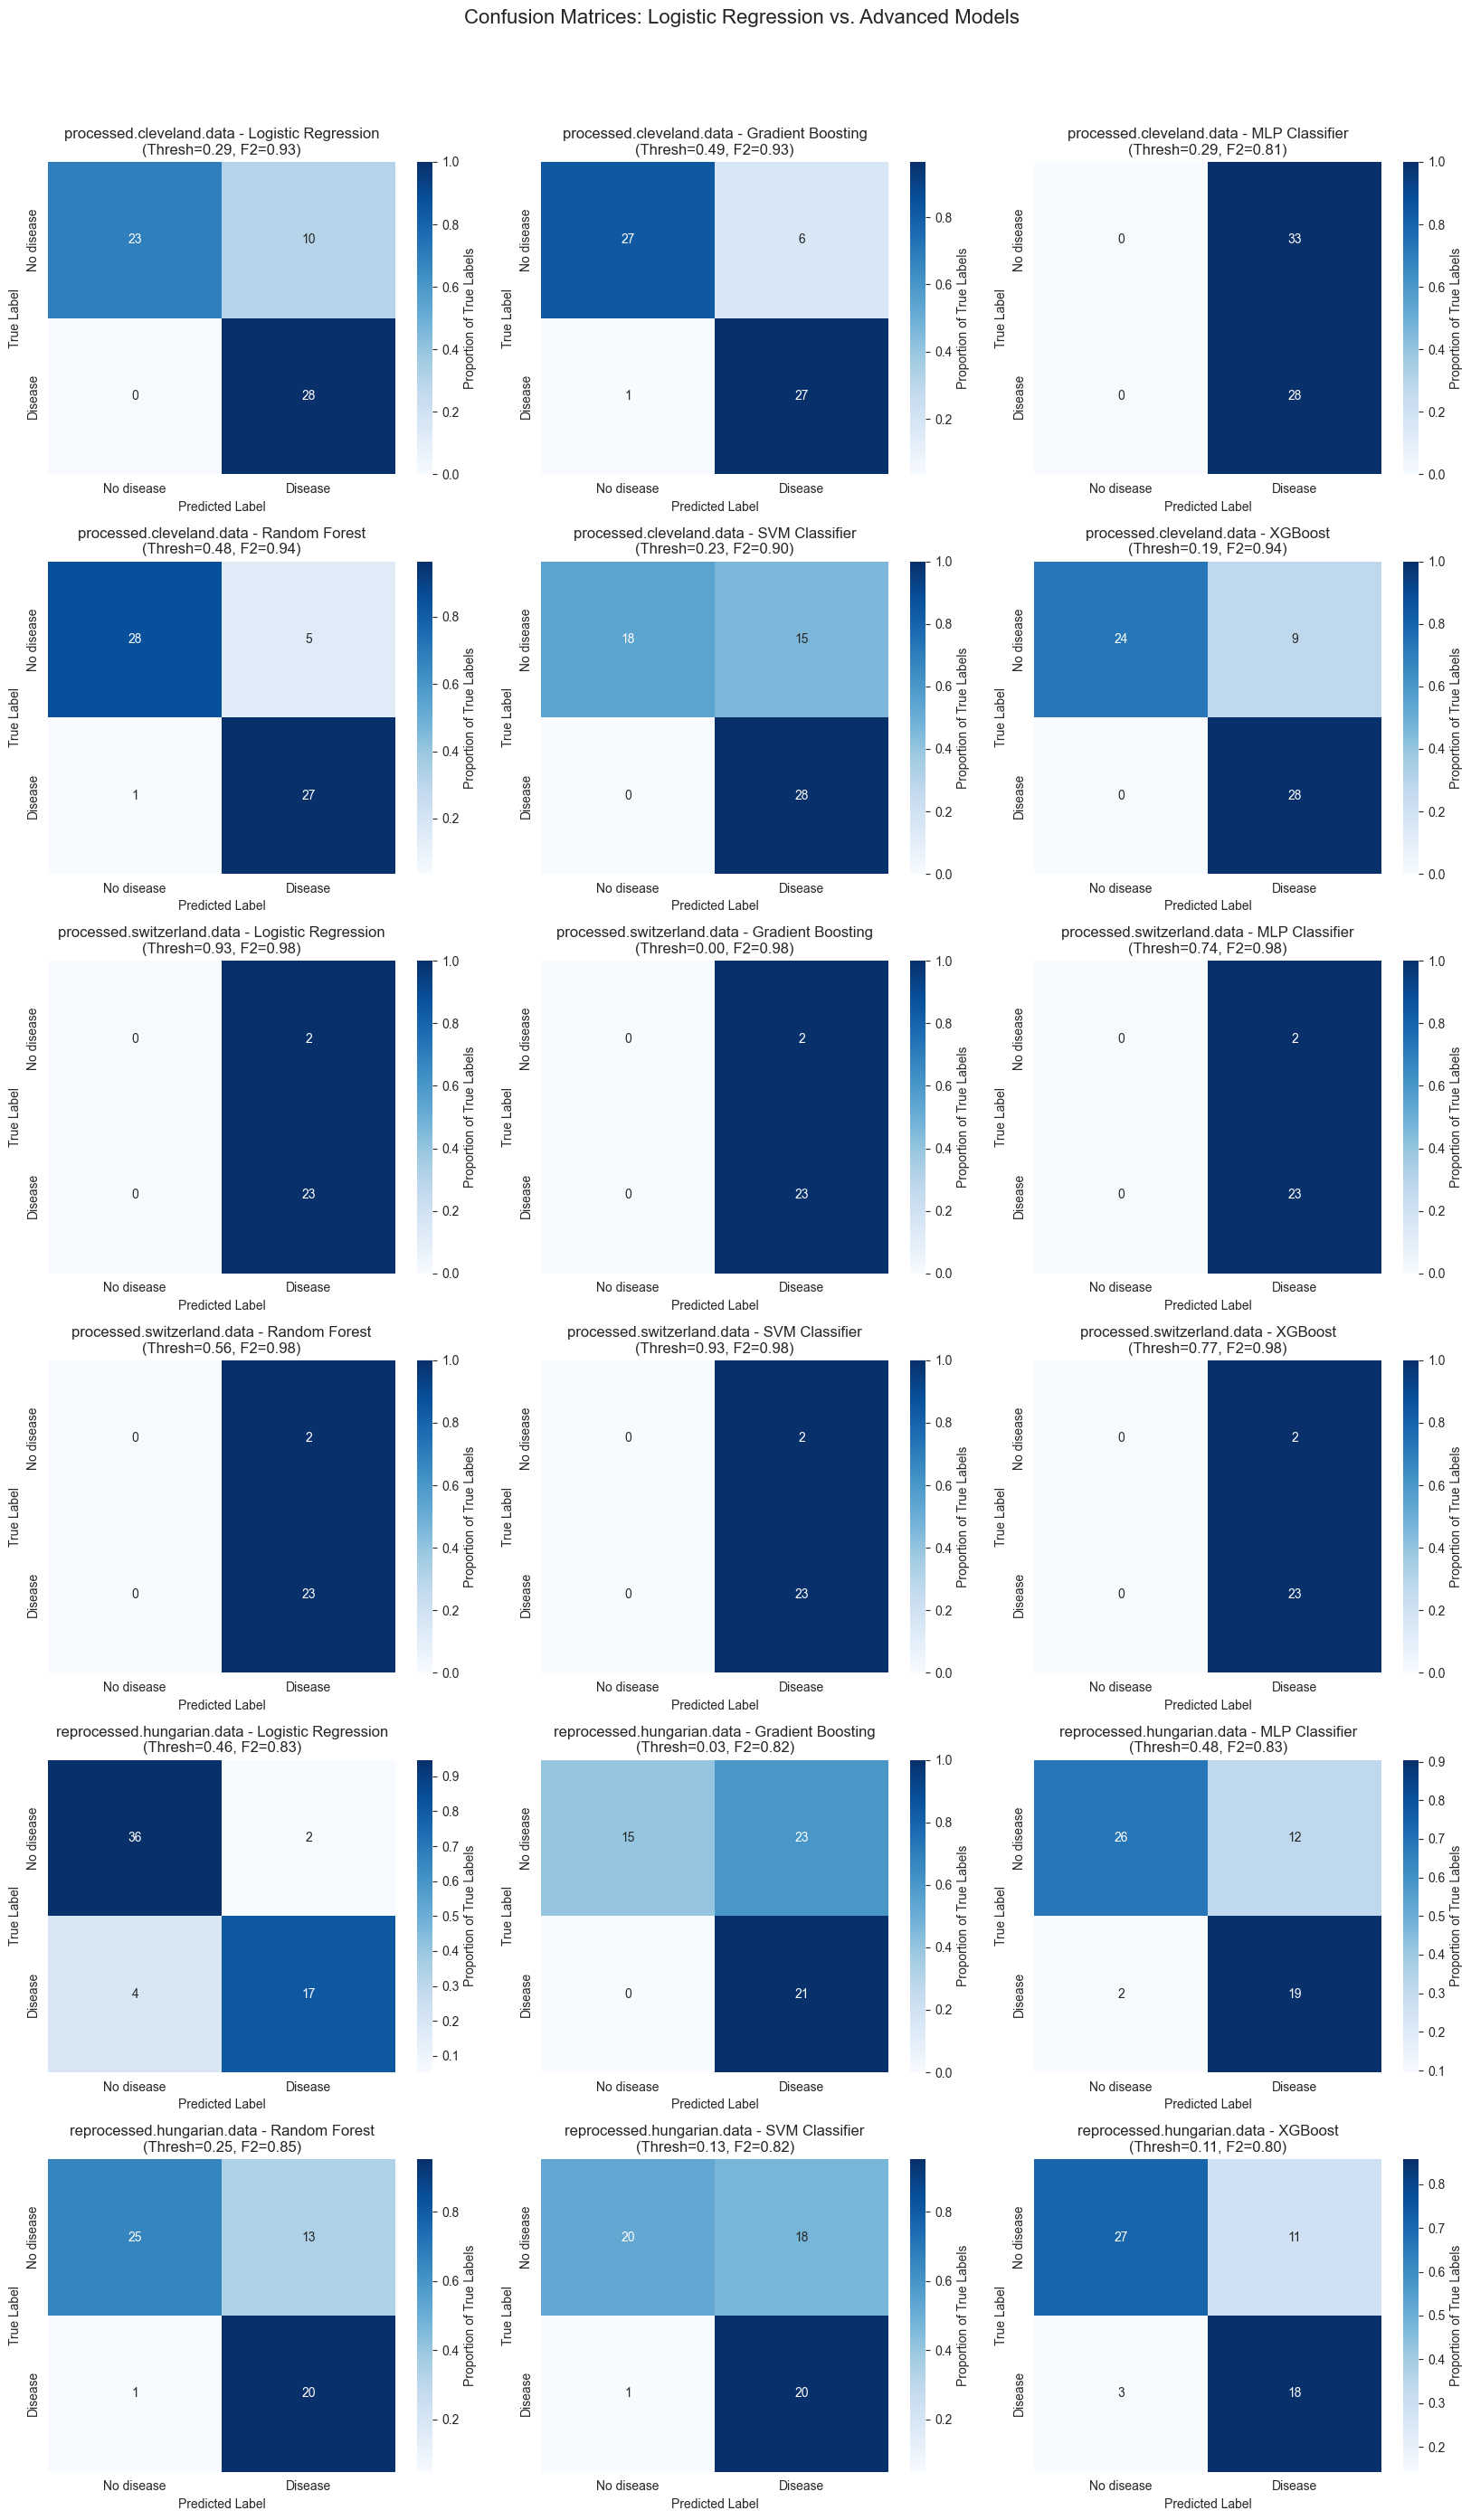

In [82]:
focused_detailed_classic_results_cm = [
    res for res in detailed_classic_results if res['Model'] in models_for_focused_plots
]
num_plots_focused_cm = len(focused_detailed_classic_results_cm)
cols_focused_cm = 3 
rows_focused_cm = math.ceil(num_plots_focused_cm / cols_focused_cm)

# Create figure only if there are plots to show
fig_focused_cm, axes_focused_cm = plt.subplots(rows_focused_cm, cols_focused_cm, 
                                               figsize=(cols_focused_cm * 5.5, rows_focused_cm * 4.5))

axes_flat_focused_cm = []
if num_plots_focused_cm > 0:
    if num_plots_focused_cm == 1:
        axes_flat_focused_cm = [axes_focused_cm]
    else:
        axes_flat_focused_cm = axes_focused_cm.flatten()

for idx, res in enumerate(focused_detailed_classic_results_cm):
    ax = axes_flat_focused_cm[idx]
    cm = res["Confusion Matrix"]
    # Ensure row sums are not zero before dividing
    row_sums = cm.sum(axis=1)
    cm_norm = cm.astype(float) / row_sums[:, np.newaxis] 
    cm_norm = np.nan_to_num(cm_norm) # Replace NaN (from division by zero) with 0
    sns.heatmap(
        cm_norm, annot=cm, fmt='d', cmap='Blues',
        xticklabels=['No disease', 'Disease'], yticklabels=['No disease', 'Disease'],
        ax=ax, cbar=True, cbar_kws={'label': 'Proportion of True Labels'}
    )
    # Show F2-Score in the title
    ax.set_title(f'{res["Dataset"]} - {res["Model"]}\n(Thresh={res["Optimized Threshold (for F2)"]:.2f}, F2={res["F2-Score (Optimized Threshold)"]:.2f})') # Corrected label to F2
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Hide unused subplots
for i in range(num_plots_focused_cm, rows_focused_cm * cols_focused_cm):
    if i < len(axes_flat_focused_cm): # Check bounds defensively
      fig_focused_cm.delaxes(axes_flat_focused_cm[i])

title_cm = 'Confusion Matrices: Advanced Models' 
if overall_best_baseline_name:
    title_cm = f'Confusion Matrices: {overall_best_baseline_name} vs. Advanced Models'
    
# Show super title and plot only if there are actual plots
if num_plots_focused_cm > 0: 
    plt.suptitle(title_cm, fontsize=16, y=1.03)
    plt.tight_layout()
    plt.show()
else: # Close the figure if no plots were added
     plt.close(fig_focused_cm)

#### 7.2.1. Confusion Matrices (Best Baseline vs. Advanced)

#### 7.2.2. Precision-Recall (P-R) Curves (Best Baseline vs. Advanced)
Each plot below shows P-R curves for different models on a specific dataset. This allows for direct comparison of model performance on that dataset. The point corresponding to the optimized **F2-score** is marked.

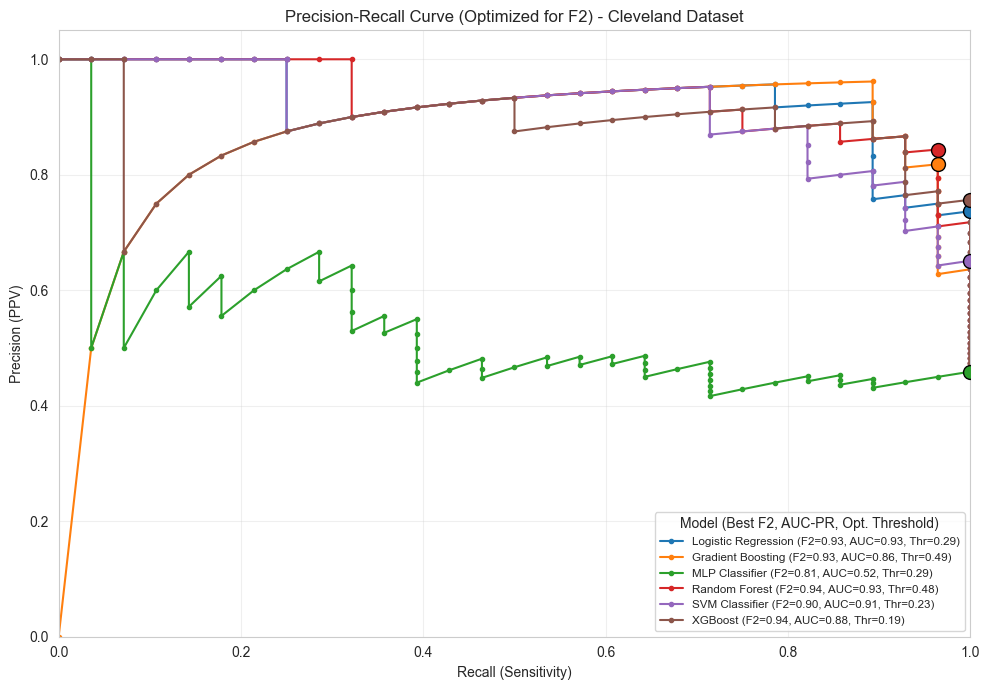

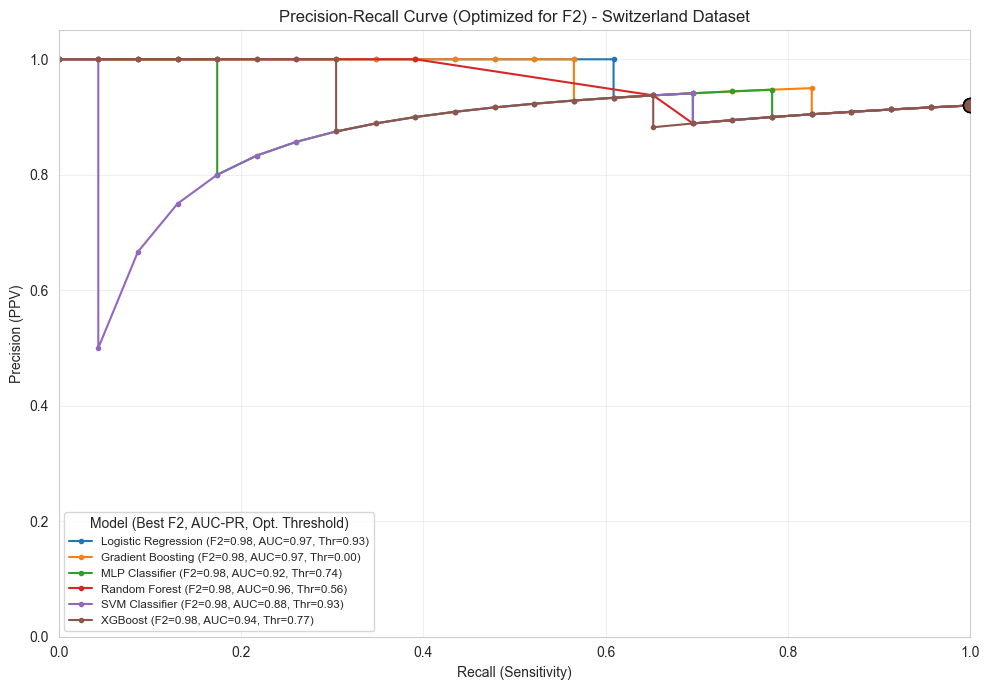

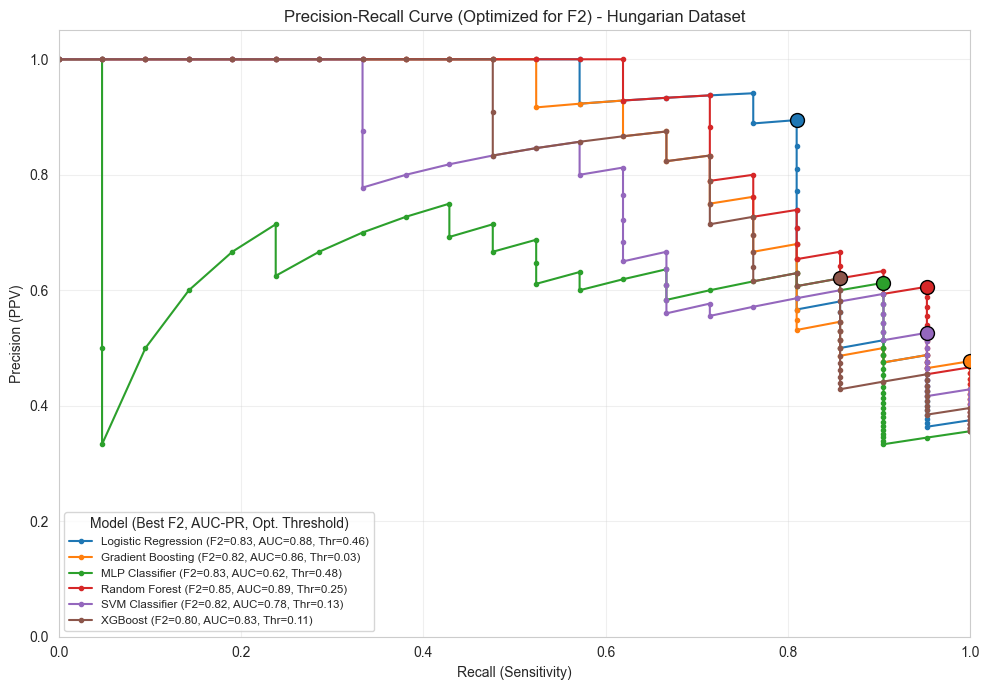

In [83]:
palette = sns.color_palette("tab10", n_colors=len(models_for_focused_plots))
model_color_map = {model: palette[i % len(palette)] for i, model in enumerate(models_for_focused_plots)}

unique_datasets = sorted(list(set(res["Dataset"] for res in detailed_classic_results)))

beta_value = 2 # Define the beta value for F2-score

for dataset_name_pr in unique_datasets:
    plt.figure(figsize=(10, 7))
    results_for_this_dataset = [res for res in detailed_classic_results if res["Dataset"] == dataset_name_pr and res["Model"] in models_for_focused_plots]
    
    if not results_for_this_dataset:
        print(f"No results to plot P-R curves for dataset: {dataset_name_pr}")
        plt.close()
        continue

    for res in results_for_this_dataset:
        model_name_pr = res["Model"]
        precisions = res["precisions_pr"]
        recalls = res["recalls_pr"]
        current_f2 = res["F2-Score (Optimized Threshold)"] # Get the optimized F2 score
        auc_pr = auc(recalls, precisions) # Calculate Area Under PR Curve
        
        # Find index for optimized threshold point on the P-R curve (based on F2)
        # Use the f2_scores_pr stored earlier
        f2_options = res["f2_scores_pr"]

        # Same logic to find the index maximizing F2
        if len(f2_options) > len(res["thresholds_pr"]):
            best_idx_pr = np.argmax(f2_options[:-1]) 
        else:
            best_idx_pr = np.argmax(f2_options)

        plt.plot(recalls, precisions, marker='.', 
                 label=f'{model_name_pr} (F2={current_f2:.2f}, AUC={auc_pr:.2f}, Thr={res["Optimized Threshold (for F2)"]:.2f})',
                 color=model_color_map.get(model_name_pr, palette[-1])) # Use mapped color
                 
        # Plot the point corresponding to the optimized threshold (which maximizes F2)
        plt.scatter(recalls[best_idx_pr], precisions[best_idx_pr], 
                    color=model_color_map.get(model_name_pr, palette[-1]), 
                    edgecolor='black', marker='o', s=100, zorder=5, label=f'_nolegend_')

    plt.title(f"Precision-Recall Curve (Optimized for F2) - {dataset_name_pr.split('.')[1].capitalize()} Dataset") # Corrected title
    plt.xlabel("Recall (Sensitivity)")
    plt.ylabel("Precision (PPV)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(alpha=0.3)
    # Update legend title to reflect F2 score
    plt.legend(title="Model (Best F2, AUC-PR, Opt. Threshold)", loc="best", fontsize='small') 
    plt.tight_layout()
    plt.show()

#### 7.2.3. F2-Score Comparison Bar Plots (Focused Comparison)

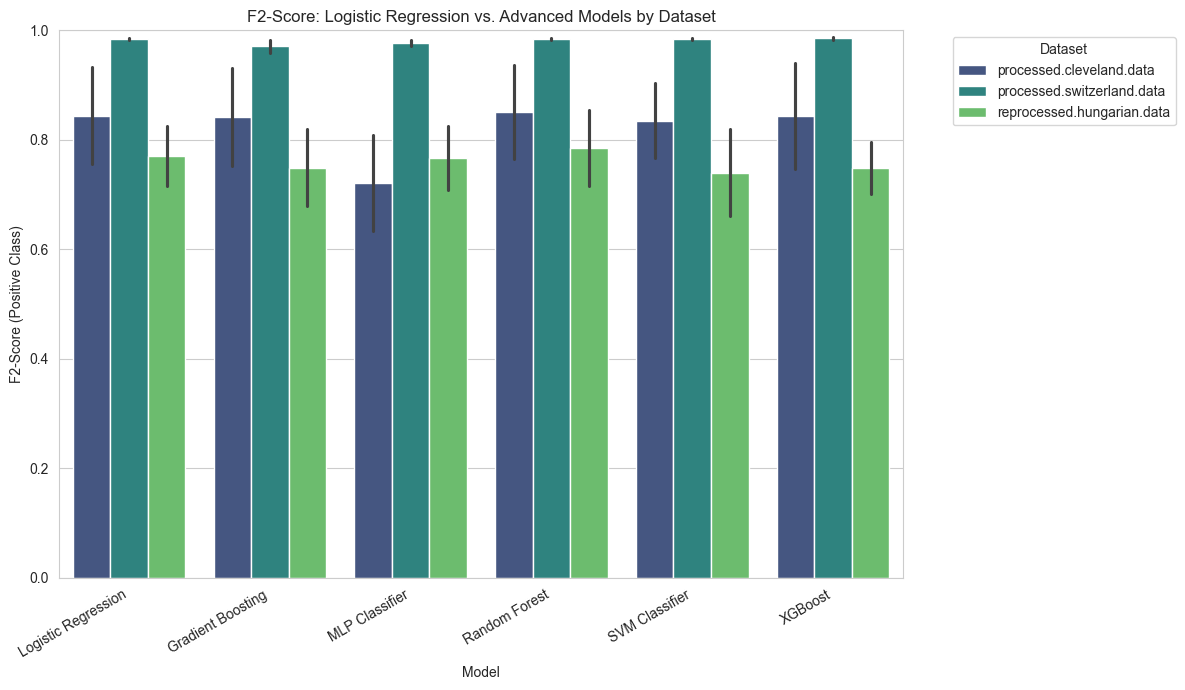

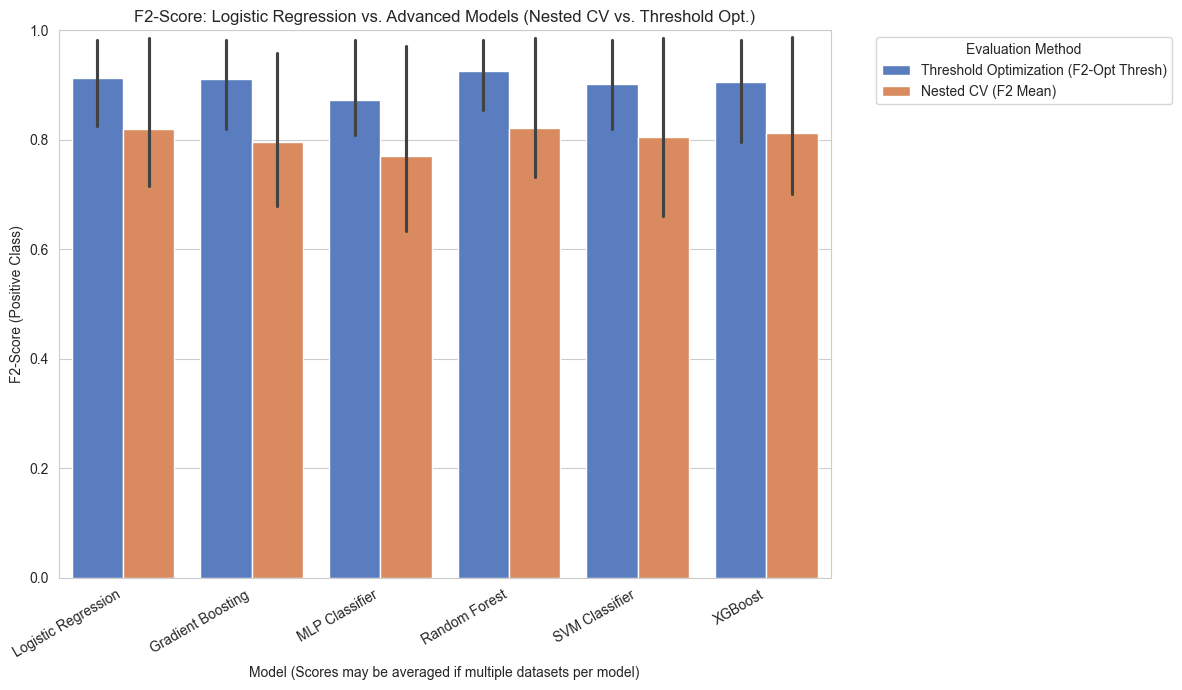

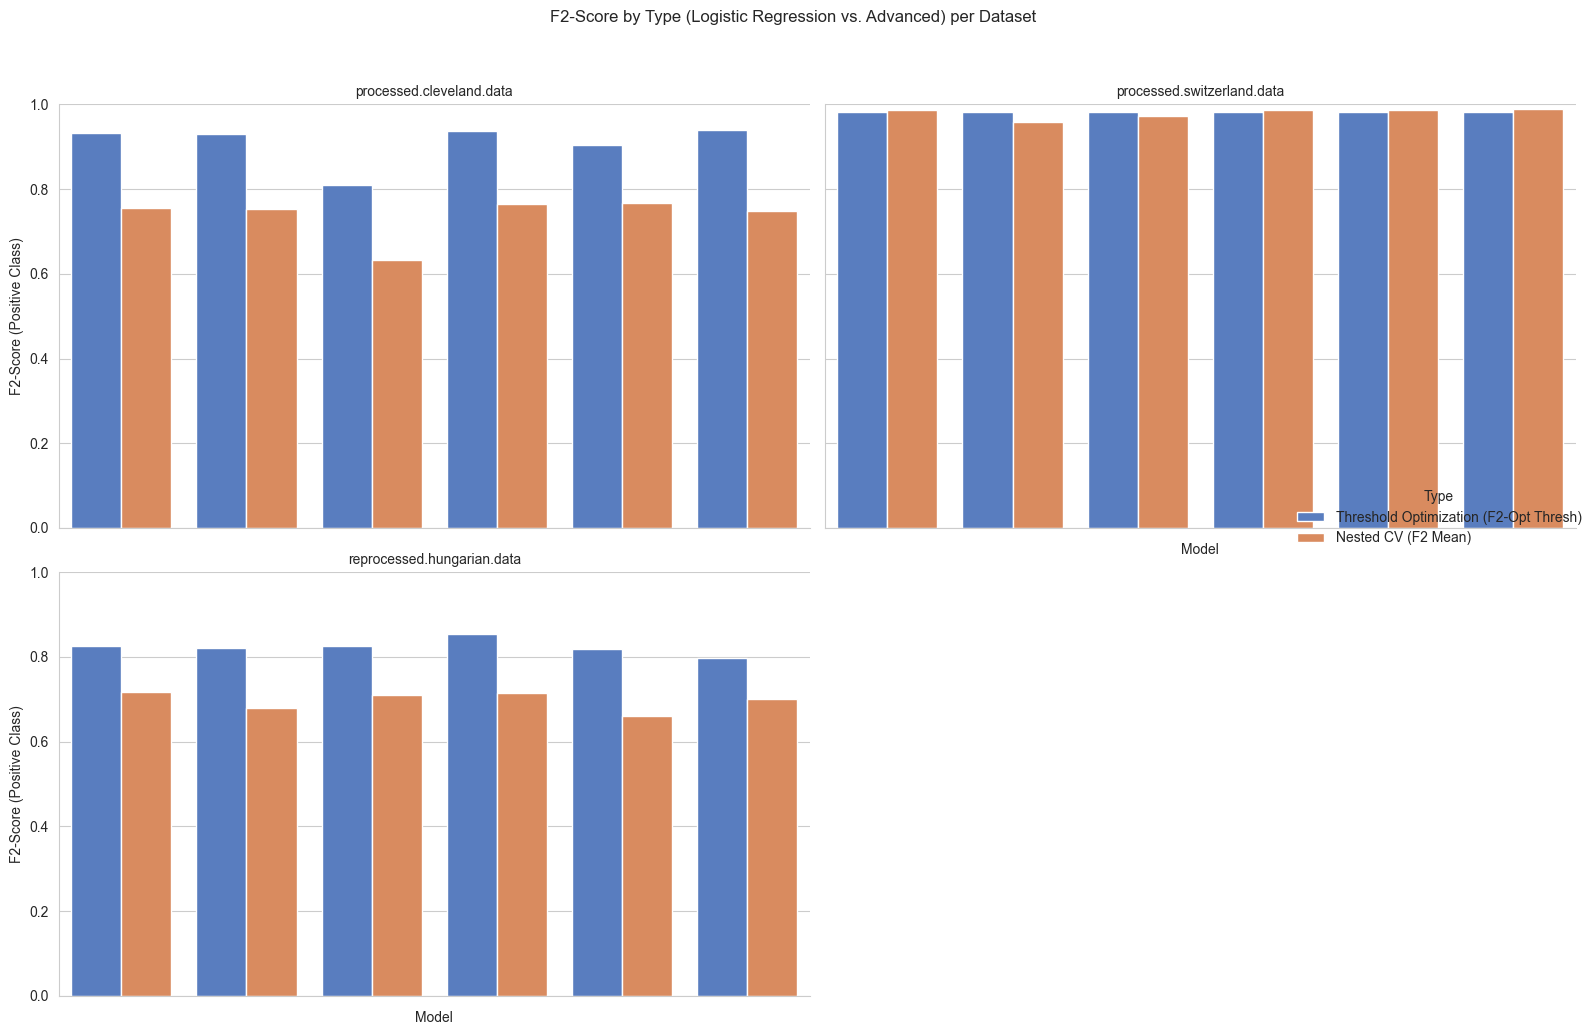

In [84]:
# Use the combined_f2_df_for_comparison DataFrame which now holds F2 scores
focused_comparison_plot_df = combined_f2_df_for_comparison[
    combined_f2_df_for_comparison['Model'].isin(models_for_focused_plots)
]

if not focused_comparison_plot_df.empty:
    # Updated titles to reflect F2-score
    title_str_dataset_hue = f"F2-Score by Dataset"
    title_str_type_hue = f"F2-Score by Evaluation Type"
    title_str_catplot = f"F2-Score by Evaluation Type per Dataset"
    if overall_best_baseline_name:
        title_str_dataset_hue = f"F2-Score: {overall_best_baseline_name} vs. Advanced Models by Dataset"
        title_str_type_hue = f"F2-Score: {overall_best_baseline_name} vs. Advanced Models (Nested CV vs. Threshold Opt.)"
        title_str_catplot = f"F2-Score by Type ({overall_best_baseline_name} vs. Advanced) per Dataset"
    
    plt.figure(figsize=(12, 7)) 
    # Use "F2-Score" column
    sns.barplot(data=focused_comparison_plot_df, x="Model", y="F2-Score", hue="Dataset", palette="viridis")
    plt.title(title_str_dataset_hue) 
    plt.ylabel("F2-Score (Positive Class)") # Corrected label
    plt.xlabel("Model")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 7))
    # Use "F2-Score" column
    sns.barplot(data=focused_comparison_plot_df, x="Model", y="F2-Score", hue="Type", palette="muted")
    plt.title(title_str_type_hue) 
    plt.ylabel("F2-Score (Positive Class)") # Corrected label
    plt.xlabel("Model (Scores may be averaged if multiple datasets per model)")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Evaluation Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Use "F2-Score" column and updated titles
    g = sns.catplot(data=focused_comparison_plot_df, x="Model", y="F2-Score", hue="Type", col="Dataset", 
                    kind="bar", palette="muted", col_wrap=2, height=5, aspect=1.3)
    g.set_titles("{col_name}")
    g.set_axis_labels("Model", "F2-Score (Positive Class)") # Corrected label
    g.set(ylim=(0,1))
    g.set_xticklabels(rotation=45, ha="right")
    plt.suptitle(title_str_catplot, y=1.03) 
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for focused F2-score comparison. Check model names and filtering.")